In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.stats import norm

c:\Users\victo\anaconda3\envs\montecarlo\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def operator(K, s, r, m, l):
    i_arr = np.linspace(1, l, l)
    sub_diag = (-r*i_arr[1:] + s**2 * (i_arr[1:])**2)/2
    diag_arr = -s**2 * (i_arr**2) - r
    sup_diag = (r*i_arr[:-1] + s**2 * (i_arr[:-1])**2)/2

    return np.diag(sub_diag, -1) + np.diag(diag_arr) + np.diag(sup_diag, 1)

def add_bc(t, K, T, r, l):
    return np.concatenate([np.array([(s**2 - r)/2 * K*np.exp(-r*(T-t))]),np.zeros(l-1)])

def payoff(x, K, put_or_call='call'):
    if put_or_call == 'call':
        return np.maximum(x - K, 0)
    elif put_or_call == 'put':
        return np.maximum(K - x, 0)

In [3]:
def finite_differences(K, s, r, T, m, l, alpha, beta, theta):
    delta = (beta - alpha)/(l+1)
    h = T/m

    print(f'delta: {delta}, h: {h}')
    
    x_grid = np.array([alpha + delta*i for i in range(1, l+1)])
    u  = [0]*(m+1)
    u[-1] = payoff(x_grid, K, 'put')   # terminal condition
    A = operator(K, s, r, m, l)

    for i in tqdm(range(m - 1, -1, -1)):
        u[i] = np.dot(np.linalg.inv(np.eye(l) - h*A),(u[i+1] + h*add_bc(i*h, K, T, r, l)))

    return x_grid, u[0]

Computation of the price

In [4]:
K = 100
s = 0.2
r = 0.05
T = 1
m = 1000
l = 500
alpha = 0
beta = 200

grid, sol = finite_differences(K, s, r, T, m, l, alpha, beta, 1)

wanted_x = 100
index = np.where(grid >= wanted_x)[0][0]
print(f'Interpolate between {grid[index-1]} and {grid[index]}')

price = sol[index-1] + (sol[index] - sol[index-1]) * (wanted_x - grid[index-1]) / (grid[index] - grid[index-1])

print(f'Price at x={wanted_x}: {price}')

delta: 0.3992015968063872, h: 0.001


100%|██████████| 1000/1000 [00:25<00:00, 38.88it/s]

Interpolate between 99.8003992015968 and 100.1996007984032
Price at x=100: 5.572949806460338


**Using exact formula**

In [5]:
def analytical(K, s, r, T, wanted_x):
    d1 = (np.log(wanted_x/K) + (r + s**2/2)*T)/(s*np.sqrt(T))
    d2 = d1 - s*np.sqrt(T)

    P = np.exp(-r*T)*K*norm.cdf(-d2) - wanted_x*norm.cdf(-d1)
    return P

P = analytical(K, s, r, T, wanted_x)
print(f'Price at x={wanted_x} (analytical): {P}')

Price at x=100 (analytical): 5.573526022256971


**Determination of the convergence order in time**

delta: 0.005988023952095809, h: 0.05


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 38.64it/s]


delta: 0.005988023952095809, h: 0.01


100%|██████████| 100/100 [00:02<00:00, 35.89it/s]


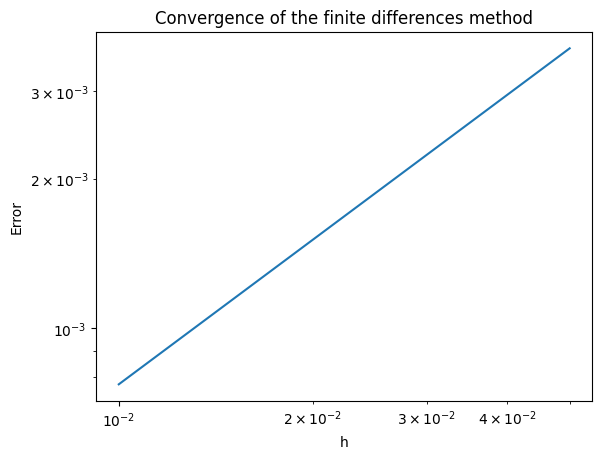

Errors: [0.003655505225998116, 0.0007718481894853432]
Order of convergence: 0.966301150482566


In [9]:
K = 1
s = 0.2
r = 0.05
T = 1
l = 500
alpha = 0
beta = 3

delta = (beta - alpha)/(l+1)
wanted_x = 1

h_values = [0.05, 0.01]

grid = np.array([alpha + delta*i for i in range(1, l+1)])
analytical_sol = analytical(K, s, r, T, grid)

solutions = []
errors = []

for h in h_values:
    m = int(T/h)
    grid, sol = finite_differences(K, s, r, T, m, l, alpha, beta, 1)
    solutions.append(sol)
    errors.append(np.sqrt(np.sum((sol - analytical_sol)**2)))

plt.plot([h for h in h_values], errors)
plt.title('Convergence of the finite differences method')
plt.xlabel('h')
plt.ylabel('Error')
plt.xscale('log')
plt.yscale('log')
plt.show()
print('Errors:', errors)
print('Order of convergence:', np.log(errors[-1]/errors[-2])/np.log(h_values[-1]/h_values[-2]))

**Order of convergence in space**

delta: 0.02, h: 0.002


100%|██████████| 500/500 [00:02<00:00, 245.42it/s]


delta: 0.01, h: 0.002


100%|██████████| 500/500 [00:05<00:00, 95.78it/s] 


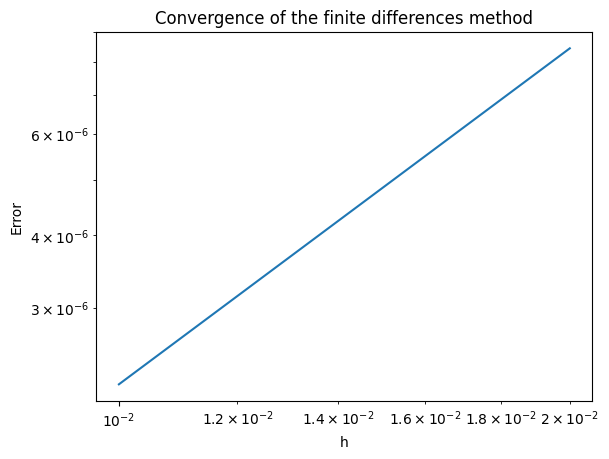

Errors: [8.4403078650059e-06, 2.2085211753072205e-06]
Order of convergence: 1.9342149580018004


In [11]:
K = 1
s = 0.2
r = 0.05
T = 1
m = 500
alpha = 0
beta = 3

wanted_x = 1

delta_values = [0.02, 0.01]

solutions = []
errors = []

for delta in delta_values:
    l = int((beta - alpha)/delta) - 1
    grid, sol = finite_differences(K, s, r, T, m, l, alpha, beta, 1)
    analytical_sol = analytical(K, s, r, T, grid)
    solutions.append(sol)
    errors.append(np.sqrt(np.sum((sol - analytical_sol)**2))*delta)

cv_order = np.log(errors[-1]/errors[-2])/np.log(delta_values[-1]/delta_values[-2])

plt.plot([delta for delta in delta_values], errors)
plt.title('Convergence of the finite differences method')
plt.xlabel('h')
plt.ylabel('Error')
plt.xscale('log')
plt.yscale('log')
plt.show()
print('Errors:', errors)
print('Order of convergence:', cv_order)